# Velocity Discretization in the Lattice Boltzmann Method
by Javier Meseguer de Paz

In [4]:
import sympy
import re
from sympy import oo
from sympy import S
from sympy.interactive.printing import init_printing
init_printing(use_unicode=False, wrap_line=False)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.colors import LightSource
import math
from IPython.display import Markdown as md

In [5]:
def display_variable(name, value):
    display(sympy.Eq(S(name),value,evaluate=False))

In [6]:
[rho, ux, uy, xix, xiy, omega, wi, cs, cix, ciy] = sympy.symbols('rho u_x u_y xi_x xi_y omega w_i c_s c_{ix} c_{iy}', real=True)

Let's define some variables. $\xi$ will be a particle velocity, while $u$ is the fluid (macroscopic) velocity.

In [7]:
xi=sympy.Matrix(2,1, [xix, xiy])
ci=sympy.Matrix(2,1, [cix, ciy])
u=sympy.Matrix(2, 1, [ux, uy])

## Define the Particle Distribution Function in terms of Hermite Polynomials

Our Particle Distribution Function (henceforth PDF) has the following form when in equilibrium, for isothermal fluids:

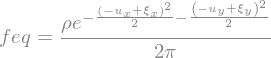

In [8]:
display_variable('feq',rho/(2*sympy.pi)*sympy.exp(-(xi-u).dot(xi-u)/2))

This equation comes from the Maxwell-Boltzmann Distribution in a pretty straightforward way (https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution)

We can _approximate_ this function in terms of Hermite Polynomials up to second order. The reason for this will be apparent later.

To do this we would compute the Hermite Polynomials up to second order, the projection of $feq$ onto them, and finally we would multiply the resulting coefficients with the polynomials themselves to get a new $feq$ that would look like:

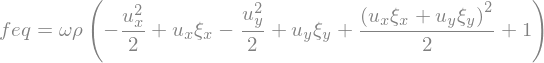

In [9]:
feq=omega*rho*(1 + (ux*xix+xiy*uy) + S(1)/2*((ux*xix+xiy*uy)**2 - (ux*ux+uy*uy)))
display_variable('feq',feq)

where $\omega$ is the Hermite weight function, whose value is:

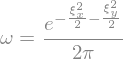

In [10]:
def wd(d, x):
    return 1/((2*sympy.pi)**sympy.Rational(d/2))*sympy.exp(-(x.dot(x))/2)
display_variable('omega',wd(2,xi))

substituting:

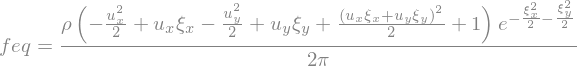

In [11]:
def wd(d, x):
    return 1/((2*sympy.pi)**sympy.Rational(d/2))*sympy.exp(-(x.dot(x))/2)
feq=feq.subs(omega,wd(2,xi))
display_variable('feq',feq)

Note that this is an approximation (this form of the equation is not exactly equivalent to the initial one) because we truncated the series. However, we will see that this approximation is enough to conserve density and momemtum.

## Let's see what it looks like

For a density of $\rho=1.0$ and a velocity $u_x=0.5$ and $u_y=0.25$, for example, this is what the PDF looks like.

In fact, these are the values we would store for each node in the lattice if we could store values for an infinite number of velocities.

In [12]:
def evalfeq(value_xix, value_xiy):
    return feq.subs([(rho, 1),(ux, 0.5),(uy, 0.25),(xix, value_xix),(xiy, value_xiy)]).evalf()

In [13]:
def evalfeq_heightmap(values_xix, values_xiy):
    sx = len(values_xix)
    sy = len(values_xix[0])
    r = np.zeros([sx, sy])
    for i in range(0, sx):
        for j in range(0, sy):
            value_xix = values_xix[i,j]
            value_xiy = values_xiy[i,j]
            v = evalfeq(value_xix, value_xiy)
            r[i,j]=v
    return r

In [14]:
# Make data.
X = np.arange(-3, 3, 0.1)
Y = np.arange(-3, 3, 0.1)
X, Y = np.meshgrid(X, Y)
Z = evalfeq_heightmap(X, Y)

vx = np.arange(0, 0.5, 0.1)
vy = 0.25*vx

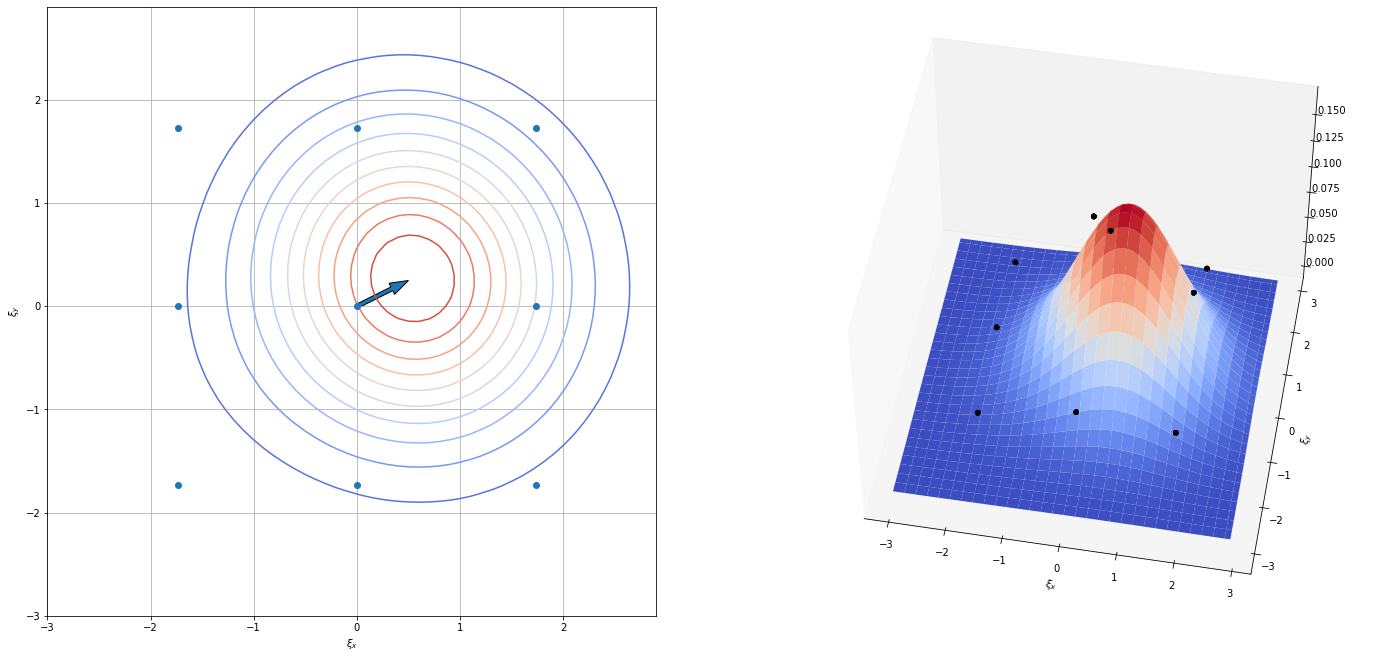

In [15]:
s = np.sqrt(3)
sx = [0, 0, 0, +s, -s, +s, +s, -s, -s]
sy = [0, s, -s, 0, 0, +s, -s, +s, -s]
sX, sY = np.meshgrid(sx, sy)

fig = plt.figure(figsize=(24,12))

ax = fig.add_subplot(1, 2, 1)

ax.contour(X, Y, Z, 15, cmap=cm.coolwarm, antialiased=True)
#ax.clabel(surf, inline=1, fontsize=10)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('$\\xi_x$')
ax.set_ylabel('$\\xi_y$')
ax.grid(True)
ax.plot(sx, sy, 'o')
plt.arrow(0, 0, 0.5, 0.25, length_includes_head='True',width=0.04)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(sX, sY, evalfeq_heightmap(sX, sY)+0.03,c='black')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True, shade=True)

ax.clabel(surf, inline=1, fontsize=10)
ax.set_aspect('auto', adjustable='box')
ax.set_xlabel('$\\xi_x$')
ax.set_ylabel('$\\xi_y$')
ax.view_init(elev=50., azim=-80)
ax.grid(False)

plt.show()

## Symbolic integration

Since the PDF gives us the particle density for a given particle velocity, if we integrate the PDF over all the particle velocities we get the density.

In [16]:
display(md(r"density=$\int_{-\infty}^{+\infty} feq \, d\xi$="))
sympy.integrate(feq, (xix, -oo, oo), (xiy, -oo, oo))

density=$\int_{-\infty}^{+\infty} feq \, d\xi$=

The PDF for a given particle velocity multiplied by that particle velocity yields the momentum density for the particles that have that particle velocity. Thus, integrating this over all velocities, we get the momentum density of the fluid.

In [17]:
display(md(r"momx=$\int_{-\infty}^{+\infty} feq \cdot \xi_x \, d\xi=$"))
sympy.integrate(feq * xix, (xix, -oo, oo), (xiy, -oo, oo))

momx=$\int_{-\infty}^{+\infty} feq \cdot \xi_x \, d\xi=$

In [18]:
display(md(r"momy=$\int_{-\infty}^{+\infty} feq \cdot \xi_y \, d\xi=$"))
sympy.integrate(feq * xiy, (xix, -oo, oo), (xiy, -oo, oo))

momy=$\int_{-\infty}^{+\infty} feq \cdot \xi_y \, d\xi=$

Furthermore, this actually shows that the approximated $feq$ is enough to recover the conserved quantities (density and momentum density, which means we are conserving mass and momentum, since the domains volume doesn't change).

However, computing indefinite integrals of a continuous function such as these during the simulation is simply not feasible. First, because we would need a way to store the continuos function, and then because the integration itself is quite expensive. The usual approach would be to discretize the function by sampling it and perform numerical integration. We could do that, but LBM does it better. 

This is actually the reason why we approximated the PDF as a truncated Hermite expansion instead of using the Maxwell-Boltzmann formula directly. It so happens that our approximated PDF has the form $f=\omega Q$ with $\omega$ being the Hermite weight. A function of this form can be integrated _exactly_ by following a pretty efficient algorithm.




## Integral by Hermite-Gauss quadrature

The Hermite-Gauss quadrature rule tells us that we can integrate a function of the form $f=\omega Q$ by performing the weighted average of Q evaluated at a fixed amount of points. That is, $\int_{-\infty}^{+\infty}{\omega(\xi) Q(\xi)\, d\xi} = \sum_i^N{w_i Q(\xi_i)}$. 
Our PDF has already that form, so we can apply the rule. In our particular case, Q is second order, so we need to evaluate Q (which is just the PDF after dividing by $\omega$) at 9 different particle velocities, with the following weights:

| weight | $\xi_x$    | $\xi_y$    |
|--------|------------|------------|
| 4/9    | 0          | 0          |
| 1/9    | 0          | $+\sqrt 3$ |
| 1/9    | 0          | $-\sqrt 3$ |
| 1/9    | $+\sqrt 3$ | 0          |
| 1/9    | $-\sqrt 3$ | 0          |
| 1/36   | $+\sqrt 3$ | $+\sqrt 3$ |
| 1/36   | $+\sqrt 3$ | $-\sqrt 3$ |
| 1/36   | $-\sqrt 3$ | $+\sqrt 3$ |
| 1/36   | $-\sqrt 3$ | $-\sqrt 3$ |

In [19]:
def evalfeq_without_omega(value_xix, value_xiy):
    feq_without_weight = feq/wd(2, xi)
    return feq_without_weight.subs([(xix, value_xix),(xiy, value_xiy)])

Let's start by computing the integral of the function:

In [20]:
s = sympy.sqrt(3)
density = \
(S(4)/9)*evalfeq_without_omega(0,0) + \
(S(1)/9)*evalfeq_without_omega(0, +s) + \
(S(1)/9)*evalfeq_without_omega(0, -s) + \
(S(1)/9)*evalfeq_without_omega(+s, 0) + \
(S(1)/9)*evalfeq_without_omega(-s, 0) + \
(S(1)/36)*evalfeq_without_omega(+s, +s) +\
(S(1)/36)*evalfeq_without_omega(+s, -s) + \
(S(1)/36)*evalfeq_without_omega(-s, +s) + \
(S(1)/36)*evalfeq_without_omega(-s, -s)
display(md(r"$\sum_i{w_i \cdot Q}=$"))
display(density.simplify())

$\sum_i{w_i \cdot Q}=$

Now the moments:

In [21]:
momx = \
(S(4)/9)*evalfeq_without_omega(0,0)*0 + \
(S(1)/9)*evalfeq_without_omega(0, +s)*0 + \
(S(1)/9)*evalfeq_without_omega(0, -s)*0 + \
(S(1)/9)*evalfeq_without_omega(+s, 0)*s + \
(S(1)/9)*evalfeq_without_omega(-s, 0)*(-s) + \
(S(1)/36)*evalfeq_without_omega(+s, +s)*s +\
(S(1)/36)*evalfeq_without_omega(+s, -s)*s + \
(S(1)/36)*evalfeq_without_omega(-s, +s)*(-s) + \
(S(1)/36)*evalfeq_without_omega(-s, -s)*(-s)
display(md(r"$\sum_i{w_i \cdot Q \cdot \xi_x}=$"))
display(momx.simplify())

$\sum_i{w_i \cdot Q \cdot \xi_x}=$

In [22]:
momy = \
(S(4)/9)*evalfeq_without_omega(0,0)*0 + \
(S(1)/9)*evalfeq_without_omega(0, +s)*s + \
(S(1)/9)*evalfeq_without_omega(0, -s)*(-s) + \
(S(1)/9)*evalfeq_without_omega(+s, 0)*0 + \
(S(1)/9)*evalfeq_without_omega(-s, 0)*0 + \
(S(1)/36)*evalfeq_without_omega(+s, +s)*s +\
(S(1)/36)*evalfeq_without_omega(+s, -s)*(-s) + \
(S(1)/36)*evalfeq_without_omega(-s, +s)*s + \
(S(1)/36)*evalfeq_without_omega(-s, -s)*(-s)
display(md(r"$\sum_i{w_i \cdot Q \cdot \xi_y}=$"))
display(momy.simplify())

$\sum_i{w_i \cdot Q \cdot \xi_y}=$

We can see that we get the same results as those of the symbolic integrals. That is, by performing this simple sums we are integrating _exactly_ our approximate PDF.

## Getting rid of the $\sqrt 3$ terms

There is one inconvenience, though: We have a lot of $\sqrt 3$ where we have to evaluate our function. We would prefer to have integer particle velocities, because those velocities with correspond to moving exactly one lattice node per timestep (or none, in the case of the zero velocity). This would make the streaming part of the LBM algorithm trivially easy. 

We can get such velocities simply by using a change of variable. We can write our approximate PDF to use $c_i=\xi c_s$ (with $c_s=1/\sqrt 3$) instead of $\xi$.

This means the $\xi$ terms become $c_i \cdot c_s$ and the $u$ terms become $u \cdot c_s$ (because $u=\int_{-\infty}^{+\infty} f \cdot \xi \, d\xi$ and is thus dependant on $\xi$, and needs to compensate for the change of variable).

By doing this, we would need to evaluate this changed function in:

| $w_i$  | $c_{ix}$   | $c_{iy}$   |
|--------|------------|------------|
| 4/9    | 0          | 0          |
| 1/9    | 0          | $+1$       |
| 1/9    | 0          | $-1$       |
| 1/9    | $+1$       | 0          |
| 1/9    | $-1$       | 0          |
| 1/36   | $+1$       | $+1$       |
| 1/36   | $+1$       | $-1$       |
| 1/36   | $-1$       | $+1$       |
| 1/36   | $-1$       | $-1$       |

which are all integer velocities.

The final form of the function we need to evaluate is thus $feq_i=w_i\cdot Q$ (the PDF with the Hermite weight substituted by the integration weight) is:

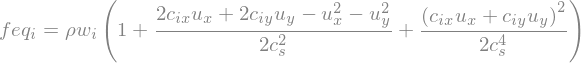

In [23]:
feq_i = (feq/wd(2, xi) * wi).simplify()
feq_i = feq_i.subs([(xix,cix/cs),(xiy,ciy/cs),(ux,ux/cs),(uy,uy/cs)])
feq_i = feq_i.apart(cs).collect(wi).collect(rho)
display_variable('feq_i',feq_i)

Which is the usual form of the equilibrium PDF in LBM. And since we are only evaluating this function (per directions) this is the only one we need to store in the lattice.

## Non equilibrium PDFs

Up to now, we have only talked about the PDF for a fluid in equilibrium. During the course of the simulation, the PDF will most likely deviate from its equilibrium value. It is assumed, however, that the PDF will still be fairly close to an equilibrum distribution and will still be well represented by a truncated Hermite expansion. This assumption is the one that let us integrate by using the same technique.

## Conclusion

We can see that performing the sums actually gives us the _exact_ solutions to the integrals. This means that we are solving exactly the approximate PDF (we approximated it when we wrote it as a truncated Hermite expansion). We can also see that this approximation, however, still lets us recover the conserved quantities of interest (density and momentum). We can also see how a change of variable let us store values only in integer positions of the lattice.